In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.signal import unit_impulse
#from findiff import FinDiff
#from sympy import symbols, solve

In [2]:
def forward_difference(y , dx):
    if len(y) == 1:
        return 0
    dydx = np.array(len(y)*[0.00])
    for i in range(len(y)-1):
        dydx[i] = (y[i+1] - y[i])/(dx)
    
    dydx[-1] = (y[-1] - y[-2])/(dx)
    
    return dydx
        
        

In [3]:
def disc_deriv(x , y):
    dy = np.array(len(y)*[0.00])
    num_discs = 0 #number of jumps
    size_jump = np.array([])  #size of the jump
    index_jump = np.array([] , dtype = int) #index AFTER which jump occurs
    
    for i in range(len(y)-1):
        dy[i] = (y[i+1] - y[i])
        
        if abs(dy[i]) >= np.pi:   #definining minimum size of a jump as pi
            #print("jump spotted")
            num_discs = num_discs + 1
            size_jump = np.append(size_jump , dy[i])
            #print(size_jump)
            index_jump = np.append(index_jump , i)
        
    
            
    #print(num_discs)
    function_subsets = (num_discs + 1)*[0.00]  #each element of this list will have a piece of the piecewise input function
    #print(len(function_subsets))
    #print(index_jump)
    
    if num_discs == 0:
        return y , 0
    
    starting_index = 0
    
    for i in range(len(function_subsets)-1):
        function_subsets[i] = y[starting_index:index_jump[i]+1]
        starting_index = index_jump[i]+1
    function_subsets[-1] = y[starting_index:]

    
    return function_subsets , size_jump
        
        

In [4]:
pi = np.pi

In [5]:
"""Defining the template for the di and df vectors, in terms of a quenching parameter which perturbs the v and w values"""

v_quench_param = 0.5
w_quench_param = -0.5

#N = 1000
k = np.linspace(-pi , pi , 1001)
kp = k[np.where(k==0)[0][0]:]
kp_index = np.where(k==0)[0][0]
dk = k[1]-k[0]
t = np.linspace(0 , 30 , 1000)

def v(quench = False):
    v = 1
    if quench:
        return v + v_quench_param
    else:
        return v
    
def w(quench = False):
    w = 1.5
    if quench:
        return w + w_quench_param
    else:
        return w


In [6]:
"""Now constructing the actual di and df vectors"""

di_list = len(k)*[0.0]
df_list = len(k)*[0.0]

for i in range(len(k)):
    di_list[i] = [v() + w()*np.cos(k[i]) , w()*np.sin(k[i])]
    df_list[i] = [v(quench=True) + w(quench=True)*np.cos(k[i]) , w(quench=True)*np.sin(k[i])]

In [7]:
"""Converting the di and df lists to arrays for easy operation later"""

di = np.array(di_list)
df = np.array(df_list)

In [8]:
"""Normalizing the di and df vectors"""

di_normed = np.zeros(np.shape(di))
df_normed = np.zeros(np.shape(df))

for i in range(len(di)):
    di_normed[i] = ( 1/np.sqrt(np.sum(di[i]**2)) ) * di[i]
    df_normed[i] = ( 1/np.sqrt(np.sum(df[i]**2)) ) * df[i]

Text(0.5, 1.0, 'Representation of d vectors in k-space')

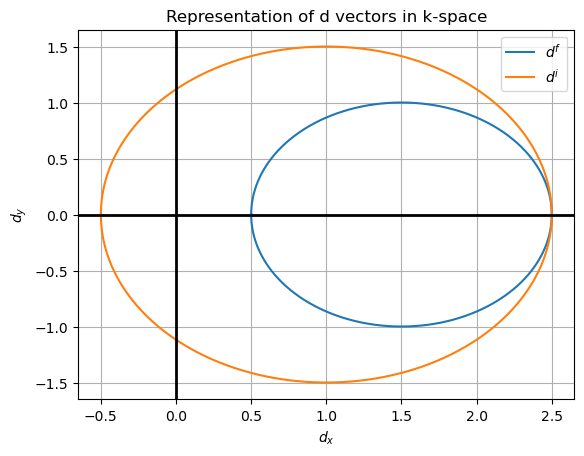

In [9]:
plt.plot(df[:,0] , df[:,1] , label = r"$d^f$")
plt.plot(di[:,0] , di[:,1] , label = r"$d^i$")
plt.xlabel(r'$d_{x}$')
plt.ylabel(r'$d_{y}$')
plt.axvline(linewidth = '2' , color = 'black')
plt.axhline(linewidth = '2' , color = 'black')
# plt.xlim(-6,6)
# plt.ylim(-6,6)
plt.grid()
plt.legend()
plt.title("Representation of d vectors in k-space")

In [10]:
"""defining cos(delta_k)"""

cos_delta_k = np.array(len(k)*[0.00])

for i in range(len(k)):
    cos_delta_k[i] = np.dot(di_normed[i] , df_normed[i])

In [11]:
"""Defining the energies as a function of k (dispersion relation)"""

Eik = np.array(len(k)*[0.00])
Efk = np.array(len(k)*[0.00])

for i in range(len(k)):
    Eik[i] = np.sqrt(np.sum(di[i]**2)) 
    Efk[i] = np.sqrt(np.sum(df[i]**2)) 


In [12]:
"""Calculating the critical momentum and critical times"""

Efkc_analytical = np.sqrt(v(quench=True)**2 + w(quench=True)**2 + 2*v(quench=True)*w(quench=True)*np.cos(2.957))

tc_analytical = pi/(2*Efkc_analytical)  #tc assuming continuum limit

index_of_kc = np.where(abs(cos_delta_k) == min(abs(cos_delta_k)))[0]

tc = pi/(2*Efk[index_of_kc])[0]  #tc calculated for our discrete array

In [13]:
"""Defining the Loschmidt amplitude and the Loschmidt return rate"""

Gk = np.zeros((len(t) , len(k)) , dtype = complex)

for i in tqdm(range(len(t))):
    for k_val in range(len(k)):
        Gk[i,k_val] = complex(np.cos(Efk[k_val]*t[i]) , -cos_delta_k[k_val]*np.sin(Efk[k_val]*t[i]))
        
LE_amp = np.array(len(t)*[1.00] , dtype = complex)

for i in tqdm(range(len(t))):
    for k_val in range(len(k)):
        LE_amp[i] = LE_amp[i]*Gk[i][k_val]
        
rate = (-1/len(k))*np.real(np.log(np.abs(LE_amp)**2))

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
def nearest_multiple_of_pi(phase):
    if phase>=0:
        return (phase//pi)*pi
    else:
        return ((phase//pi)+1)*pi
        


def make_periodic(phase):
    if nearest_multiple_of_pi(phase) >= 0:
        if (nearest_multiple_of_pi(phase)/pi)%2 == 0:
            return (phase - nearest_multiple_of_pi(phase))
        else:
            return -(pi - (phase - nearest_multiple_of_pi(phase)))
    else:
        if (nearest_multiple_of_pi(phase)/pi)%2 == 0:
            return (phase - nearest_multiple_of_pi(phase))
        else:
            return (pi + (phase - nearest_multiple_of_pi(phase)))
        


In [15]:
"""Defining the Pancharatnam Geometric Phase (PGP) and dnu, where nu = DTOP"""

PGP = np.zeros((len(t) , len(k)))
phi_dyn = np.zeros((len(t) , len(k)))


for i in tqdm(range(len(t))):
    for k_val in range(len(k)):
        phi_dyn[i,k_val] = np.angle(complex(np.cos(-Efk[k_val]*t[i]*cos_delta_k[k_val]) , np.sin(-Efk[k_val]*t[i]*cos_delta_k[k_val])))

for i in tqdm(range(len(t))):  # i know i don't need to loop this, PGP = angle(Gk) - phi_dyn will suffice, will change later
    for k_val in range(len(k)):
        PGP[i,k_val] = make_periodic(np.angle(Gk[i,k_val]) - phi_dyn[i,k_val])




    
# d_dk = FinDiff(0,dk)

# for i in range(len(t)):
#     dnu[i] = d_dk(PGP[i])

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
PGP_in_EBZ = PGP[: , np.where(k==0)[0][0]:]

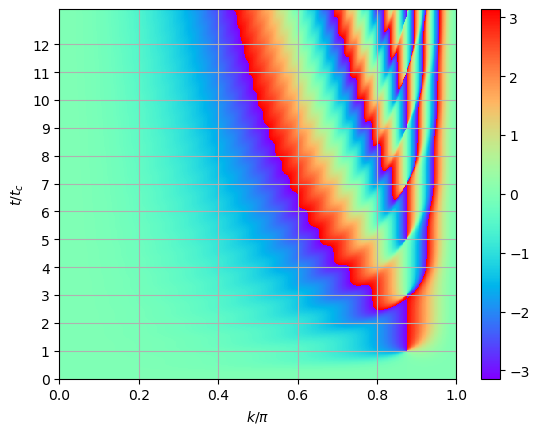

In [17]:
#%matplotlib qt
plt.pcolormesh(k/pi , t/tc , PGP , cmap = 'rainbow')
plt.colorbar()
#plt.grid()
plt.xlabel(r'$k/\pi$')
plt.ylabel(r'$t/t_c$')
# plt.clim(-8 , 0)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.yscale('log')
# #plt.xlim(10,95)
# plt.ylim(10,4000)
plt.xlim(0,1)
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid()
plt.show()


In [18]:
pieces = len(PGP)*[0.00]
jump_sizes = len(PGP)*[0.00]

for i in range(len(PGP)):
    #print("index = ",i)
    pieces[i] , jump_sizes[i] = disc_deriv( k , PGP_in_EBZ[i] )

In [19]:
dnu = len(PGP)*[0.00]

for i in range(len(dnu)):
    if not np.shape(jump_sizes[i]): #if there is no jump...
        dnu[i] = forward_difference(pieces[i] , dk)
        
    else:  #if there is a nonzero number of jumps
        dnu[i] = [forward_difference(arr , dk) for arr in pieces[i]]
        
        

In [20]:
nu = len(PGP)*[0.00]

for i in range(len(nu)):
    if not np.shape(jump_sizes[i]): #if there is no jump...
        nu[i] = (1/(2*pi))*np.trapz(pieces[i] , dx = dk)
        
    else:  #if there is a nonzero number of jumps
        nu[i] = (1/(2*pi))*(np.sum([np.trapz(arr , dx = dk) for arr in pieces[i]]) + np.sum(jump_sizes[i]))

Text(0.5, 0, 'Time')

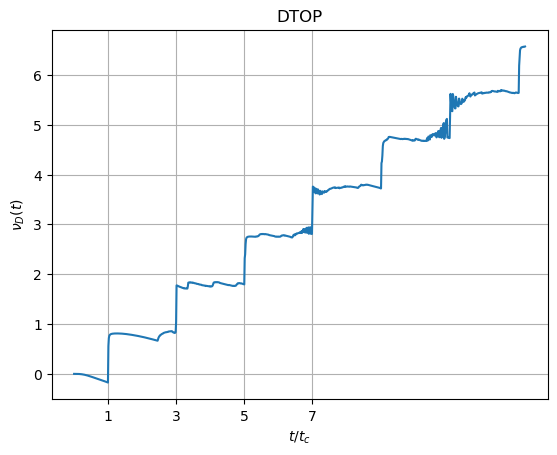

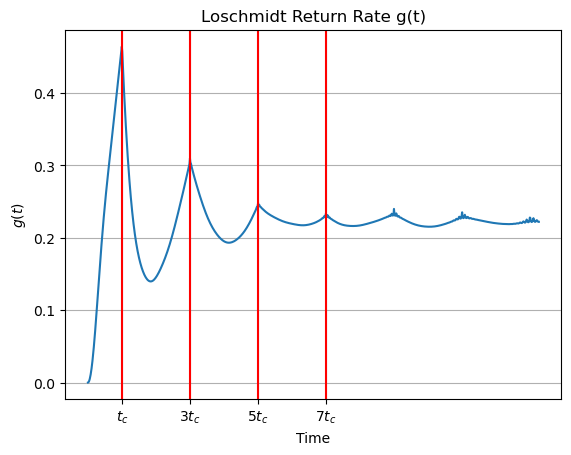

In [21]:
plt.plot(t/tc , nu)
plt.ylabel(r'$\nu_{D}(t)$')
plt.xlabel(r'$t/t_c$')
plt.xticks([1 , 3 , 5 , 7])
plt.grid()
# plt.xlim(0,1)
# plt.ylim(0,40)
#plt.axvline(tc)
plt.title("DTOP")
#plt.axvline(tc , color='red')
#plt.ylim(-2,2)
#plt.savefig("DTOP_plot.png")

plt.figure()
plt.plot(t,rate)
plt.grid()
plt.axvline(tc , color='red')
plt.axvline(3*tc , color='red')
plt.axvline(5*tc , color='red')
plt.axvline(7*tc , color='red')
plt.xticks([tc , 3*tc , 5*tc , 7*tc] , [r'$t_c$' , r'$3t_c$' , r'$5t_c$' , r'$7t_c$'])
plt.title("Loschmidt Return Rate g(t)")
plt.ylabel(r'$g(t)$')
plt.xlabel('Time')


#plt.ylim(0,2)
#plt.xlim(0,1)